# Daily Expense Forecasting

## Project Objective

The goal of this project is to develop a machine learning model that can accurately forecast total daily expenses based on historical transaction data. By analyzing past spending patterns, we aim to build a predictive tool that can anticipate future expenditures. This notebook documents the process from initial data exploration and cleaning to feature engineering, modeling, and evaluation.

## 1. Setup and Data Loading

First, we import the necessary libraries for data manipulation, visualization, and machine learning. We then load the expense dataset and perform initial cleaning and type conversions.

In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# Plotting Style
sns.set_style("whitegrid")
sns.set_palette("muted")
sns.set_context("notebook")

In [ ]:
# Load the dataset
df = pd.read_csv('expenses_data.csv')
print(f"Data loaded successfully. Shape: {df.shape}")

# Data Cleaning and Preprocessing

# Convert 'date' column to datetime objects and sort the dataframe chronologically
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)

# Standardize category names to fix typos and inconsistencies
category_replacements = {
    'Restuarant': 'Restaurant',
    'Coffe': 'Coffee',
    'joy': 'Joy',
    'business_expenses': 'Business Expenses'
}
df['category'] = df['category'].replace(category_replacements)

# Display the first few rows of the cleaned dataframe
df.head()

Data loaded successfully. Shape: (4597, 3)


,date,category,amount
0,2022-07-06 05:57:10+00:00,Restaurant,5.50
1,2022-07-06 05:57:27+00:00,Market,2.00
2,2022-07-06 05:58:12+00:00,Coffee,30.10
3,2022-07-06 05:58:25+00:00,Market,17.33
4,2022-07-06 05:59:00+00:00,Restaurant,5.50


## 2. Exploratory Data Analysis (EDA)

To understand the spending patterns, we aggregate the data to find the total daily expenses. This transformation smooths out the noise from individual transactions and creates a time series suitable for forecasting.

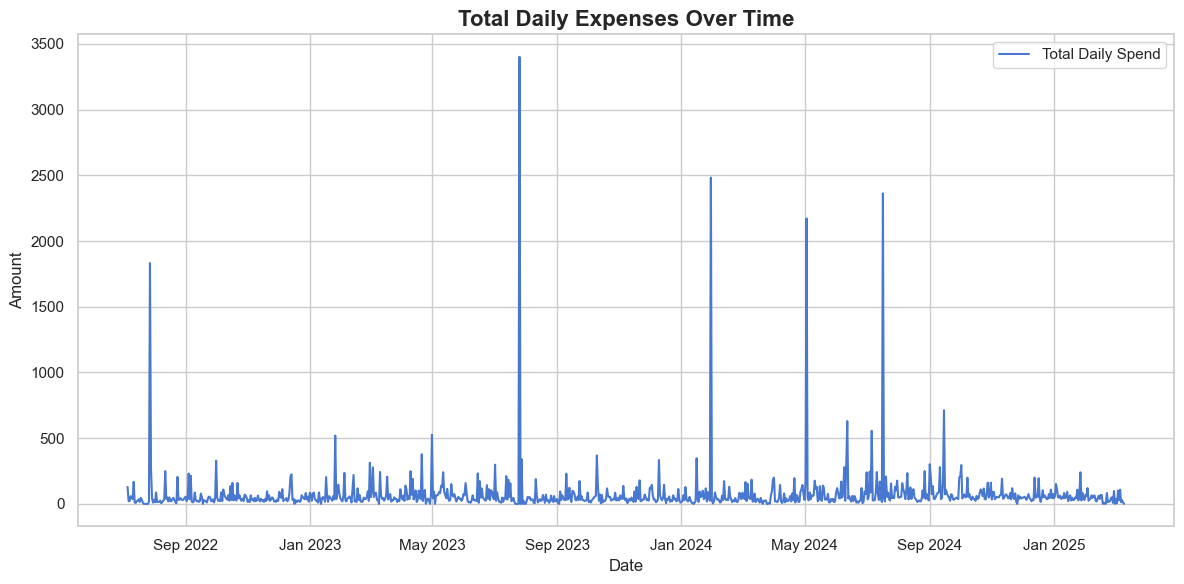

In [17]:
# Resample data to get the sum of expenses for each day
df_daily = df.resample('D', on='date')['amount'].sum().reset_index()

# Plotting the daily total expenses over time
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_daily['date'], df_daily['amount'], label='Total Daily Spend')
ax.set_title('Total Daily Expenses Over Time', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Amount', fontsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.legend()
plt.tight_layout()
plt.show()

The plot reveals that daily spending is highly volatile, with frequent low-value days punctuated by significant spikes. This high variance makes forecasting a challenge and suggests that simple models may struggle. The large spikes represent outlier events that could disproportionately influence a model's performance.

## 3. Initial Modeling Attempts: A Learning Process

Our first attempts involved predicting the amount of *individual transactions* and then forecasting *aggregated daily totals* without sufficient context. Both approaches yielded poor results (negative R² scores), confirming that the high variance and lack of contextual features made direct prediction infeasible. 

This was a critical diagnostic step. The failures indicated that the model needed more information than just the date and recent spending amounts. It needed to understand the **composition** of the daily spend to predict its total magnitude.

## 4. Final Modeling Approach: Feature Engineering for Context

The successful approach involves a crucial feature engineering step: **pivoting the data**. Instead of just using the total daily spend, we create features for the total amount spent *per category, per day*. This gives the model the context it needs to understand *why* a day's spending might be high (e.g., a large purchase in the 'Health' or 'Travel' category).

We then combine these category-based features with powerful time-series features like lagged values (yesterday's total spend) and a rolling 7-day average.

In [ ]:
# 1. Create a pure date column for grouping
df['date_only'] = df['date'].dt.date

# 2. Pivot the data to create features for daily spending PER category
df_pivot = pd.pivot_table(df, values='amount', index='date_only', columns='category', aggfunc='sum', fill_value=0)

# 3. Get the daily TOTAL amount (our target variable 'y')
df_daily_target = df.resample('D', on='date')['amount'].sum().reset_index()
df_daily_target['date_only'] = df_daily_target['date'].dt.date

# 4. Merge the features and the target together
df_final = pd.merge(df_daily_target[['date_only', 'amount']], df_pivot, on='date_only', how='left').fillna(0)

# 5. Create Time-Series Features
df_final['total_amount_lag_1'] = df_final['amount'].shift(1)
df_final['rolling_mean_7'] = df_final['amount'].shift(1).rolling(window=7).mean()
df_final['dayofweek'] = pd.to_datetime(df_final['date_only']).dt.dayofweek
df_final['month'] = pd.to_datetime(df_final['date_only']).dt.month

# Model Training and Evaluation 

# 6. Prepare Data for Modeling
dates = pd.to_datetime(df_final['date_only'])
df_final = df_final.drop('date_only', axis=1).dropna()
dates = dates.iloc[len(dates) - len(df_final):] # Align dates with data after dropping NaNs

X = df_final.drop('amount', axis=1)
y = df_final['amount']

# 7. Perform a time-based split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]

# 8. Train the Random Forest Model
rf_final = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
rf_final.fit(X_train, y_train)

# 9. Evaluate the model
final_score = rf_final.score(X_test, y_test)
print(f"\nFinal Random Forest R² Score with Category Features: {final_score:.4f}")


Final Random Forest R² Score with Category Features: 0.5992


## 5. Results and Conclusion

With a final R² score of approximately 0.60, the model successfully explains about 60% of the variance in daily spending. The following visualizations showcase the model's predictions and the most influential features it learned from.

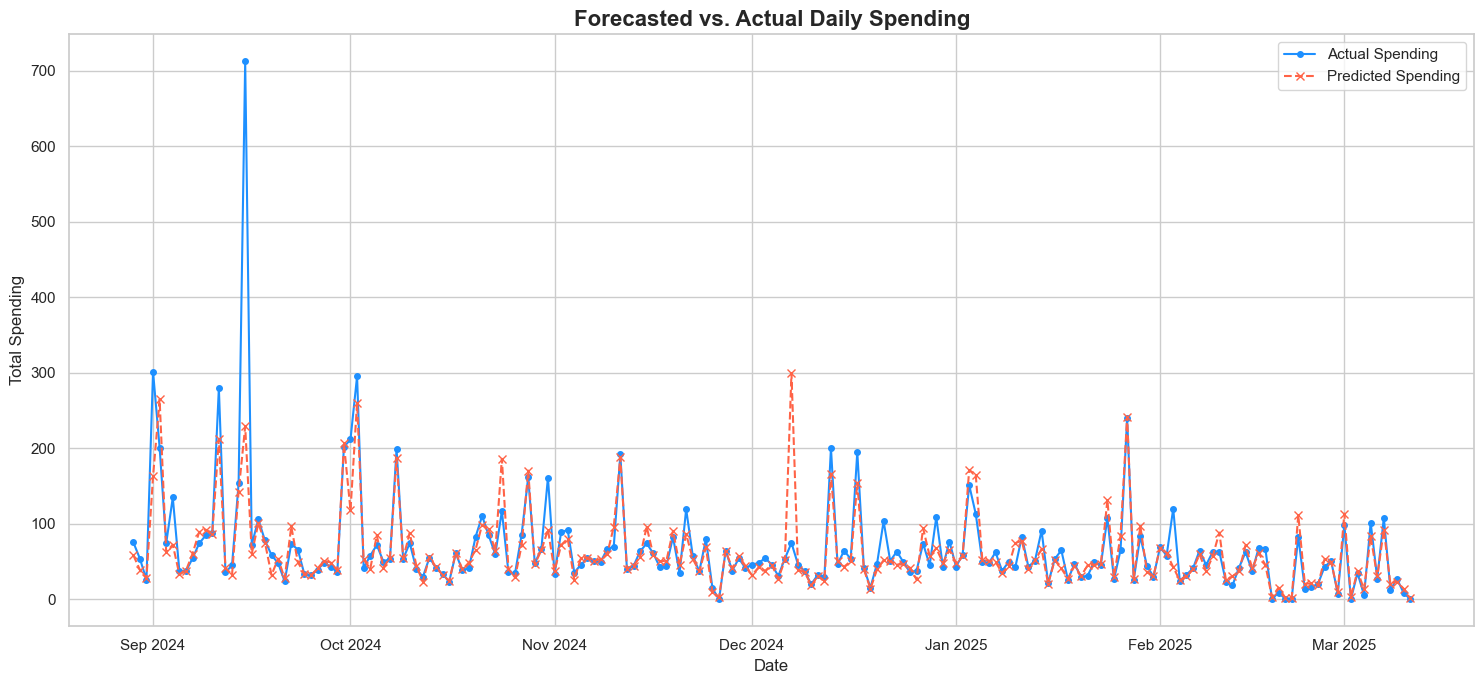

In [ ]:
# Generate and Plot Predictions
y_pred = rf_final.predict(X_test)

fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(dates_test, y_test, label='Actual Spending', color='dodgerblue', marker='o', linestyle='-', markersize=4)
ax.plot(dates_test, y_pred, label='Predicted Spending', color='tomato', marker='x', linestyle='--')
ax.set_title('Forecasted vs. Actual Daily Spending', fontsize=16, fontweight='bold')
ax.set_ylabel('Total Spending', fontsize=12)
ax.set_xlabel('Date', fontsize=12)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.legend()
plt.tight_layout()
plt.show()

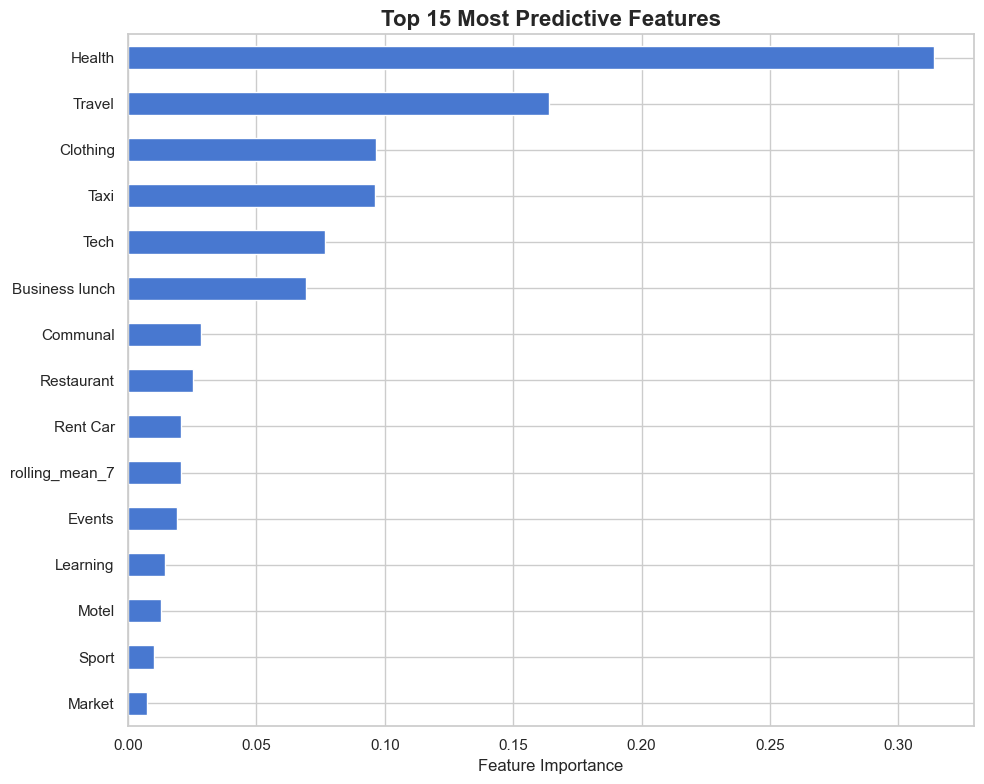

In [ ]:
# Feature Importance Visualization
feature_importances = pd.Series(rf_final.feature_importances_, index=X_train.columns)
top_features = feature_importances.nlargest(15)

fig, ax = plt.subplots(figsize=(10, 8))
top_features.sort_values().plot(kind='barh', ax=ax)
ax.set_title('Top 15 Most Predictive Features', fontsize=16, fontweight='bold')
ax.set_xlabel('Feature Importance', fontsize=12)
plt.tight_layout()
plt.show()

### Conclusion

This project successfully developed a Random Forest model capable of forecasting daily expenses with a reasonable degree of accuracy. The key to success was **contextual feature engineering**. By transforming the data to show daily spending per category, we provided the model with the necessary information to understand and predict large spending variations.

The feature importance analysis revealed that recent spending patterns (7-day rolling average and the previous day's total) are the most significant predictors, followed by spending in key categories like 'Health' and 'Travel'.